# Basic Statistics (Part 2)

### Prerequisite

* $\texttt{numpy}$ and $\texttt{matplotlib}$.

### New skills

* Probability notation and basic rules

* Likelihood functions

* Fitting a model

In [1]:
# Let's start with importing our packages
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

# We can beautify our plots by changing the matplotlib settings a little
plt.rcParams['font.size'] = 18
matplotlib.rcParams['axes.linewidth'] = 2
matplotlib.rcParams['font.family'] = "serif"

### Part 1: probability functions

We are now comfortable drawing random numbers using $\texttt{python}$ and have experimented with Gaussian and Poisson distributions. Before we fully apply these skills to astronomy, let's review one additional tool: probability density functions (pdf).

PDFs tell us what values a random variable can take and how likely certain values are. If we make a large number of draws from a random variable, the resulting histogram will closely match the PDF.

There are two rules PDFs follow. Let's call our random variable $X$ and its PDF $p(X)$.

1. The probability that a realization of $X$ falls in the range $x_1$ to $x_2$ is:
$$p(x_1\leq X \leq x_2) = \int_{x_1}^{x_2} dX \cdot p(X)$$

2. All PDFs must integrate to 1:
$$\int dX \cdot p(X)=1$$

In the last notebook, we saw examples of PDFs, such as:

**Gaussian**: $p(x) = \frac{1}{\sqrt{2\pi} \sigma} e^{-\frac{(x-\mu)^2}{2\sigma^2}}$
        
**Poisson**: $P(X=k) = \dfrac{\lambda^k e^{-\lambda}}{k!}$

Let's now revisit Gaussian distributions using this new knowledge.

**Exercise:** Write a function for a gaussian PDF. The function should have the inputs `x, sigma, mu` and return `p(x)`. Using your function, plot $p(x)$ for $\sigma=1$ and $\mu=0$ (for $-3 < x < 3$). Be sure to label your plot.


Text(0, 0.5, '$p(x)$')

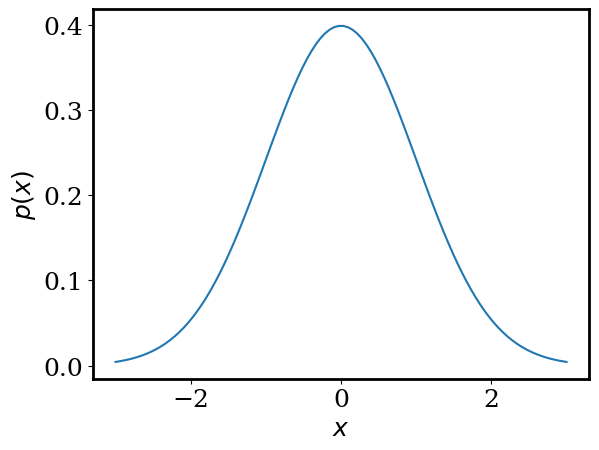

In [2]:
def gaussian_pdf(x, mu, sigma):
    return np.exp( -np.power(x-mu,2) / (2*sigma**2) ) / np.sqrt(2*np.pi*sigma)

xp = np.linspace(-3, 3, 100)
yp =  gaussian_pdf(xp, mu=0, sigma=1)

plt.plot(xp, yp)
plt.xlabel('$x$')
plt.ylabel('$p(x)$')

Great! Now we can compare our function with a histogram of random draws.

**Exercise:** Compare the Gaussian PDF (with $\sigma=1$ and $\mu=0$) to a histogram of random draws from `np.random.normal` (remember `np.random.normal` calls `mu` --> `loc` and `sigma` --> `scale`).

Make the plot with $\texttt{density=True}$ and $\texttt{density=False}$ for $\texttt{plt.hist}$? What's the difference?

For each plot, make the histogram with 10, 100, 1000, and 10000 draws? What do you notice?

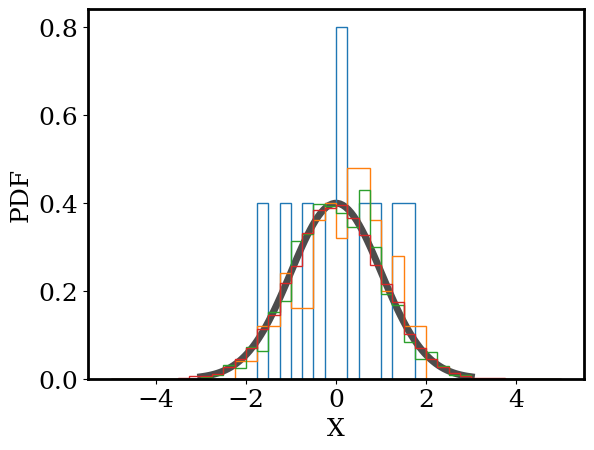

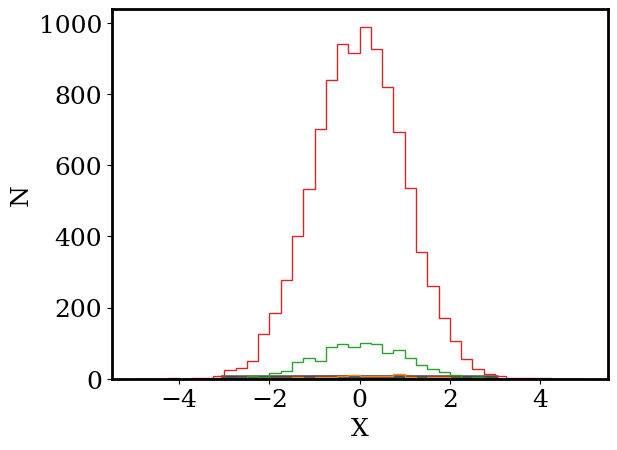

In [3]:
# parameters of our Gaussian distribution
mu = 0; sigma = 1

# evaluate the PDF on a x-grid
x = np.linspace(-3,3,100)
y = gaussian_pdf(x, mu, sigma)


# plot the histogram
for density in [True,False]:

  # plot the PDF
  plt.plot(x,y,alpha=0.7,color='k',linewidth=5)

  for n in [10, 100, 1000, 10000]:
    # draw random values using numpy
    rand = np.random.normal(loc = mu, scale = sigma, size = n)

    # plot the hist
    plt.hist(rand,density=density,bins=40,histtype='step',range=[-5,5])

  # it's always good practice to label the axes (even if it's a bit arbitrary in our case)
  _ = plt.xlabel('X')
  if density:
    _ = plt.ylabel('PDF')
  else:
    _ = plt.ylabel('N')
  plt.show()

# Part 2: fitting models to data

### Part 2.1: why fit a model?

You may rightly be asking, what does any of this have to do with astronomy? Everything (or at least a lot of things)! For us, there are two broad applications of PDFs:

1. Understanding the signal-to-noise properties of astronomical images.

2. Learning from observations by fitting models to data.

In the last notebook, we focused on the first application, here we'll focus on the second.

Let's revist the Gaia data as an example dataset.  

In [4]:
# Let's load in the data
import os
from google.colab import drive
drive.mount('/content/drive/')
os.chdir('/content/drive/Shareddrives/AST207/data')

# path to the table
path = 'gaia_15pc.csv'

# loading the table; this function assumes a 'comma separated file (aka csv)'
gaia = pd.read_csv(path)

# simple errors
gaia.loc[:,'color']     = gaia.gmag - gaia.rmag
gaia.loc[:,'color_err'] = 0.04
gaia.loc[:,'teff_err']  = 10. # K

Mounted at /content/drive/


Earlier we saw a strong correlation between the color and temperature of a star. Let's take another look.

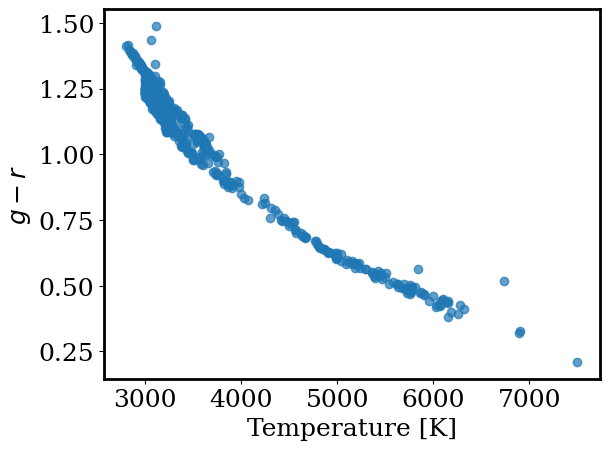

In [5]:
plt.scatter(gaia.teff,gaia.color,alpha=0.7)

_ = plt.xlabel('Temperature [K]')
_ = plt.ylabel('$g-r$')

We have a clear observational result: color and temperature of a star are strongly correlated.

However, we still don't know *how* color and temperature are related. Is the relation linear, quadratic, or perhaps much more complex? Answering this question will greatly increase our understanding of the stars in our catalog (it will also help our theorist friends try to *explain* what's happening here).

### Part 2.2: how to fit a model

From the plot above, it's reasonible to *first* assume the relation between color and temperature is linear:
$$ g-r = m \times T + b,$$
where $m$ and $b$ are coefficients we want to learn.

**Exercise:** Write a function called `linear_simple(x,m,b)` that returns `m*x+b`. Plot `linear_simple(x,m,b)` for a range of `x` values against the Gaia data. By hand, try finding the coefficients $m$ and $b$ that best fit the data.

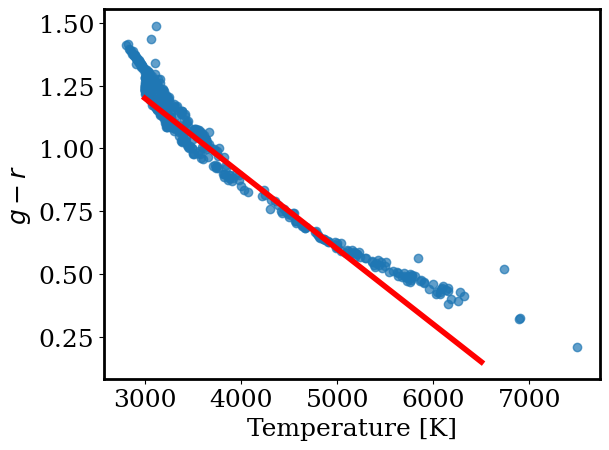

In [6]:
def linear_simple(x,m,b):
  return m*x+b

plt.scatter(gaia.teff,gaia.color,alpha=0.7)

# by hand linear fit
m = -3e-4; b = 2.1
x = np.linspace(3000,6500, 10)
plt.plot(x,linear_simple(x,m,b),color='r',linewidth=4)

_ = plt.xlabel('Temperature [K]')
_ = plt.ylabel('$g-r$')

What if we want a more robust approach?

For simplicity, let's imagine we have only one data point, a single star of temperature $5000 \pm 10 K$ and color $g-r=0.6 \pm 0.2$.

We can now ask, for a given set of values of $m,b$ how *likely* were we to have observed $g-r=0.6$ given that the star's temperature is $5000$ K? Thankfully, we just learned about PDFs! Assuming the uncertainties are well described by a Gaussian function (this is typically true, except for a few special cases we will discuss) the likelihood of measuring $g-r=0.6$ is:
$$ \ln p(g-r=0.6 \mid b, m, T = 5000) = - \frac{1}{2} \Big ( \frac{ [0.6 - (m\times5000K+b)]^2 }{0.2^2+(m\times10K)^2} + \ln (2 \pi [0.2^2+(m\times10K)^2]) \Big ) $$
notice we took the natural log to undo the exponential. This is an example of a likelihood function.

Of course, one data point is certainly not enough to fit our model with. How does the likelihood function work with multiple datapoints? Assuming each datapoint is independent we simply consider the product of each datapoint's likelihood function. In our case, 'independent' means that the measurements for one star do not dependent on the measurements for the others, which is usually a safe assumption. If we consider a second star with $g-r=1.25 \pm 0.3$ and a  temperature of $3000 \pm 50$ K, the likelihood of observing both stars is then:
$$ \ln p(g-r= \{0.6, 1.25 \} \mid b, m, T = \{ 5000, 3000 \}) \propto - \frac{1}{2} \Big ( \frac{ [0.6 - (m\times5000k+b)]^2 }{ 0.2^2+(m\times10K)^2 } + \ln (2 \pi [0.2^2+(m\times10K)^2]) \Big ) - \frac{1}{2} \Big ( \frac{ [1.25 - (m\times3000k+b)]^2 }{0.3^2+(m\times30K)^2}  + \ln (2 \pi [0.3^2+(m\times30K)^2]) \Big ). $$

We are now ready to write our generalized likelihood function for a sample of $N$ measurements (indexed by $i=1,\dots,N$):
$$ \ln p( g-r \mid b, m, T) \propto - \frac{1}{2} \sum \Big ( \frac{ [ (g-r)_i - (m\times T_i +b)]^2 }{ \sigma_{(g-r)_i} ^2 +(m\times \sigma_T~K)^2 } + \ln (2 \pi [\sigma_{(g-r)_i}^2+(m\times \sigma_T~K)^2])  \Big ). $$

It's important to remember our two key assumptions (all of which are reasonable in this case):

1. Measurement uncertainties are Gaussian
2. Measurements are independent of each other

[Note, this is my hand-wavy explanation of the likelihood function, while trying to side step Bayes. Definetely feel free to iterate on this or we can simply introduce the likelihood funciton as a black box]

### Part 2.3: fitting a model with python

**Exercise:** We need two new functions.

First, we need to update our linear model to return both the model prediction (i.e., the color of a star for a given temperature) and the uncertainty in the model prediction (if we are very uncertain about $T$, our model can't make a precise prediction for $g-r$). Let's use the structure `linear(theta, T, T_error)` where `theta` is a list containing `[m,b]`. Using a list for the parameters will make our lives easier later. The function should now return `T * m+b` and `T_error * m`.

Second, let's write the likelihood function in python. It should have the structure: `log_likelihood_function(theta, func, g_r, g_r_error, T, T_error)` where `theta` is a list of parameters to the function `func` (for example, if can set `func=linear` then `theta=[m,b]`).

In [14]:
def linear(theta, T, T_error = 0):
    m,b = theta

    model = T * m + b
    model_error = T_error * m

    return model, model_error

def log_likelihood_function(theta, func, g_r, g_r_error, T, T_error):
    model, model_error = func(theta, T, T_error)

    error2 = g_r_error**2 + model_error**2

    return -np.sum( (np.power(g_r-model,2) / error2) + np.log(2 * np.pi * error2) )

We want to find the set of coefficients that *maximimize* the likelihood function for our Gaia dataset. To do so, we will use the $\texttt{scipy.optimize.minimize}$ function. This tool finds the combination of parameters that *minimizes* the input function.

Since we want to maximimize and the tool we have minimizes, we first have to make sure our function is equal to negative the likelihood function. Let's do this as simple as possible and define:


```
def minus_log_likelihood_function(theta, func, g_r, g_r_error, T, T_error):
  return - log_likelihood_function(theta, func, g_r, g_r_error, T, T_error)
```



**Exercise:** Use `scipy.optimize.minimize` to minimize `minus_log_likelihood_function.` Use the command:


```
import scipy

out = scipy.optimize.minimize(minus_log_likelihood_function, x0=[-3e-4,2.1],
                        args=(linear, gaia.color, gaia.color_err,
                                             gaia.teff,  gaia.teff_err),
                              bounds = [[-5e-4, 0],[0,4]] )
```



The best fit values are stored in `out.x`

Plot the best fit linear function against your by hand optimization.

In [15]:
def minus_log_likelihood_function(theta, func, g_r, g_r_error, T, T_error):
  return - log_likelihood_function(theta, func, g_r, g_r_error, T, T_error)

In [16]:
import scipy

out = scipy.optimize.minimize(minus_log_likelihood_function, x0=[-3e-4,2.1],
                        args=(linear, gaia.color, gaia.color_err,
                                             gaia.teff,  gaia.teff_err),
                              bounds = [[-5e-4, 0],[0,4]] )

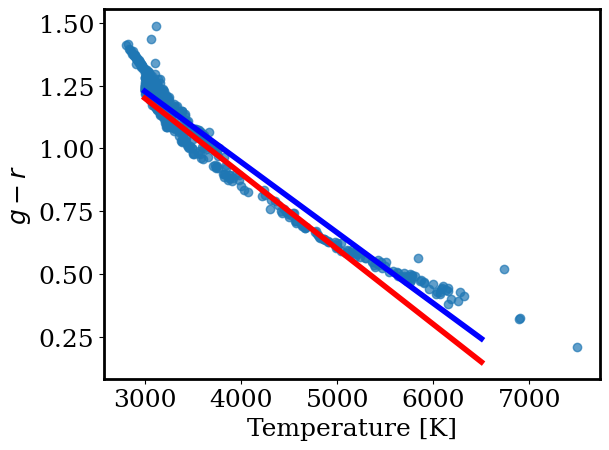

In [18]:
plt.scatter(gaia.teff,gaia.color,alpha=0.7)

# by hand linear fit
x = np.linspace(3000, 6500, 10)
plt.plot(x, linear_simple(x,m,b),color='r',linewidth=4)
plt.plot(x, linear_simple(x,*out.x),color='b',linewidth=4)

_ = plt.xlabel('Temperature [K]')
_ = plt.ylabel('$g-r$')

The linear model works okay but not great. Let's also try a model where color is *inversely* proportional to temperature:
$$ g-r = b / T + c $$

**Exercise:** write a function `inverse(theta, T, T_error = 0)` that returns `model = (m / T) + b` and `model_error = (T_error/T) * m / T.` Then use `scipy.optimize.minimize` to find the best fit parameters. Try fitting the function by hand to find good values for `x0` (the initial guess) and the bounds. Compare the best fit inverse function to the best fit linear function.

In [19]:
def inverse(theta, T, T_error):
    m,b = theta

    model = (m / T) + b
    model_error = (T_error/T) * m / T

    return model, model_error

In [20]:
out_inverse = scipy.optimize.minimize(minus_log_likelihood_function, x0=[4.932e+03, -3.696e-01],
                        bounds = [(1e3,1e4),(-10,10)],
                        args=(inverse, gaia.color, gaia.color_err,
                                             gaia.teff,  gaia.teff_err) )

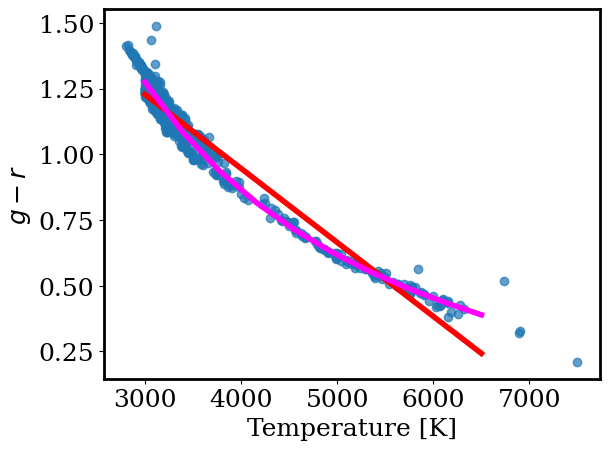

In [21]:
plt.scatter(gaia.teff,gaia.color,alpha=0.7)

# by hand linear fit
x = np.linspace(3000, 6500, 10)

# linear fit
m,b = out.x
plt.plot(x, m*x+b,color='r',linewidth=4)

m,b = out_inverse.x
plt.plot(x, m/x+b,color='magenta',linewidth=4)

_ = plt.xlabel('Temperature [K]')
_ = plt.ylabel('$g-r$')

### Part 2.4: comparing model fits

[I think we can cut this? or leave it as a majors only extension? -Jared]

The inverse model certainly *looks* better than the linear model. How can we ask that question quantitatively?

In [23]:
def chi2(theta, func, g_r, g_r_error, T, T_error):
    model, model_error = func(theta, T, T_error)

    error2 = g_r_error**2 + model_error**2

    return np.sum( (np.power(g_r-model,2) / error2))

In [24]:
chi2_lin = chi2(out.x, linear, gaia.color, gaia.color_err, gaia.teff,  gaia.teff_err)
chi2_inv = chi2(out_inverse.x, inverse, gaia.color, gaia.color_err, gaia.teff,  gaia.teff_err)

r_chi2_lin = chi2_lin / (len(gaia) - 2)
r_chi2_inv = chi2_inv / (len(gaia) - 2)

print('Linear model reduced chi^2: {:.2}'.format(r_chi2_lin))
print('Inverse model reduced chi^2: {:.2}'.format(r_chi2_inv))

Linear model reduced chi^2: 2.7
Inverse model reduced chi^2: 0.99


In terms of reduced $\chi^2$, the $g-r \propto T^{-1}$ model is favored over $g-r \propto T$. So what? Well, we've just rediscovered Wein's law. (insert blurb on Wein's law here and how color is a proxy for $\lambda_\mathrm{max}$)

$$ \lambda_\mathrm{max} \propto 1 / T $$

### Resources

* [General overview of statistics rules](https://machinelearningmastery.com/bayes-theorem-for-machine-learning/)
* [Qualitative introduction to Bayes' Theorem](https://towardsdatascience.com/intro-to-bayesian-statistics-5056b43d248d)
* [Penn State STAT 414](https://online.stat.psu.edu/stat414/book), wonderful mid-high level introduction to statstics

### Textbooks (available online)
* Higher level textbook (Modern Mathematical Statistics with Applications, 2nd ed)
* Introductory level textbook (OpenIntro Statistics 4th edition)